
Application : reconnaissance d'images. le dataset MNIST_fashion. 70,000 images en niveau de gris (28X28) sur 10 articles (manteau, basket,..) à classer. https://keras.io/api/datasets/fashion_mnist/

Importantion des modules. Il faut utiliser la version Python 3.5 au moins et aussi bien Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 requis
import sys
assert sys.version_info >= (3, 5)


# TensorFlow ≥2.0 requis
import tensorflow as tf
assert tf.__version__ >= "2.0"

# imports commun
import numpy as np
import os

# pour rendre stable l'exécution relativement aux nombres aléatoire générés.
np.random.seed(42)

# pour une meilleure visibilité des figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#importation du module keras
from tensorflow import keras



# Chargement des données
Keras dispose de fonctions utilitaires pour récupérer et charger les jeux de données. Il y a une différence par rapport à scikit-learn, chaque image est représentée non pas sous forme d'un tableau à une dimension de 784 éléments, mais sous forme d'un tenseur en 3D. Par ailleurs, les intensités des pixels sont représentées par des entiers (de 0 à 255) plutôt que des nombres à virgule flottante (0.0 à 255.0).
Le dataset est déjà divisé en jeu d'entrainement et jeu de test. Il est peut être judicieux de faire une autre division pour avoir un jeu de validation.


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


Le jeu d'entrainement contient 60.000 images à niveau de gris de 28X28 pixels:

In [3]:
X_train_full.shape

(60000, 28, 28)

Chaque intensité du pixel est representé par un octet (0 to 255):

In [4]:
X_train_full.dtype

dtype('uint8')

Créons un petit jeu de validation en divisant de nouveau le jeu d'entrainement.
Puisque nous allons entrainer avec la descente du garident, nous allons mettre à l'échelle les variables d'entrée. Pour une question de simplicité, nous allons réduire les intensités de pixels à la plage 0-1 en divisant par 255,0 (cela convertit en nombres à virgile flottante):


In [5]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Vous pouvez visualisez une image la fonction imshow de Matplotlib:

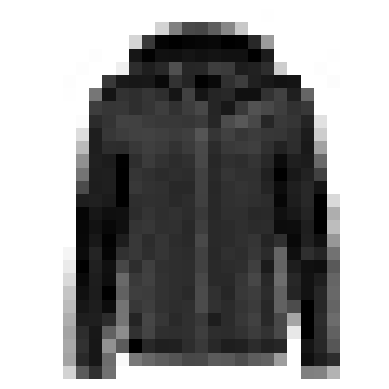

In [6]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

les labels (classes) sont représentés par des entiers d'Identification (ID) entre 0 et 9 :

In [7]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Mais dans MNIST, lorsque l'étiquette est égale à 5, cela signifie que l'image représente le chiffre manuscrit 5. En revanche, avec Fashion MNIST, nous avons besoin de la liste des noms de classes pour savoir ce que nous manipulons. Voici les classes correspondantes :

In [8]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

par exemple, la première image du jeu d'entraînement correspond à l'article coat:

In [9]:
class_names[y_train[0]]

'Coat'

le jeu de validation contient 5,000 images, et le jeu de test contient 10,000 images:

In [10]:
X_valid.shape

(5000, 28, 28)

In [11]:
X_test.shape

(10000, 28, 28)

Montrons quelques éléments du jeu de donnnées Fashion MNIST


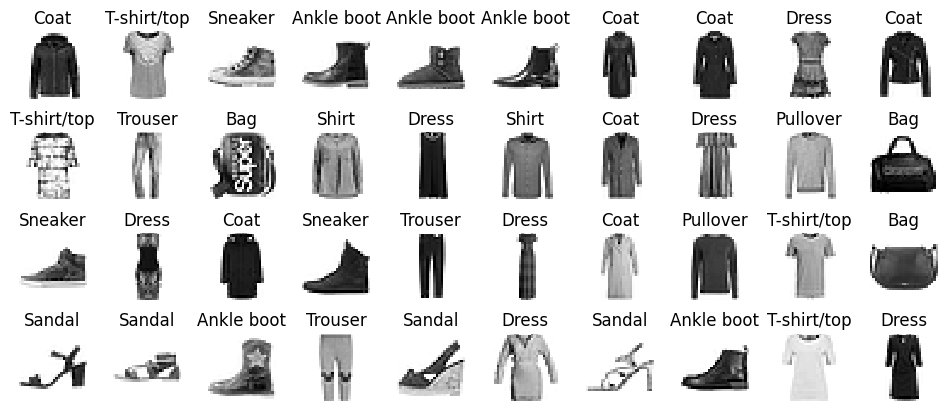

In [12]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Créons un modele PMC avec l'API Sequential.
1. La premiere ligne du code crée un modèle Sequential. C'est la maniere la plus simple de créer un RNA avec keras. Il est constitué d'une seule pile de couches connectées sous forme séquentielle.
2. Ensuite, nous ajoutons la couche Flatten-aplatissement- dans le but de convertir chaque image d'entrée en un tableau monodimensionnel
3. Ensuite nous ajoutons une couche cachée de 300 neurones. Elle utilise la fonction d'activation ReLU.
4. on ajoute une cachée Dense de 100 neurones, avec une fonction d'activation ReLU.
5. Enfin une couche de sortie Dense avec 10 neurones (un par classe) en utilisant la fonction d'activation softmax.

In [13]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [14]:
keras.backend.clear_session() # re-initialiser les états internes de tensorflow
np.random.seed(42)
tf.random.set_seed(42)

Juste une alternative au lieu d'ajouter les couches une par une, nous pouvons passer une liste de couches au moment de la création du modèle Sequential :

In [15]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Une fois que le modele a été créé, invoquer sa méthode compile() pour préciser:
1. la fonction de perte
2. optimiseur
3. la mesure de sa performance


In [17]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

Entraînement du modèle en utilisant la fonction fit(). A ce niveau, on spécifie la matrice des données et le vecteur cible ainsi que le nombre d'époques, le jeu et validation.
la fonction fit() retourne un objet history qui contient les paramètres d'entrainement, la liste des époques et le plus important, un dictionnaire
(history.histroy) donnant la perte et les autres indicateurs de performance mesurés sur le jeu d'entrainement et de validation.

In [18]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 11s 4ms/step - loss: 0.7200 - accuracy: 0.7623 - val_loss: 0.5153 - val_accuracy: 0.8254
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4876 - accuracy: 0.8287 - val_loss: 0.4356 - val_accuracy: 0.8496
Epoch 3/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4423 - accuracy: 0.8447 - val_loss: 0.5422 - val_accuracy: 0.8002
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4160 - accuracy: 0.8551 - val_loss: 0.3974 - val_accuracy: 0.8650
Epoch 5/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3971 - accuracy: 0.8608 - val_loss: 0.3773 - val_accuracy: 0.8668
Epoch 6/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3789 - accuracy: 0.8658 - val_loss: 0.3740 - val_accuracy: 0.8712
Epoch 7/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3668 - accuracy: 0.8706 - val_loss: 0.3689 - val_accuracy

In [ ]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [ ]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

En utilisant le dictionnaire de l'objet history retourné par la fonction fit(), on peut tracer le graphique des performances en fonction des époques.

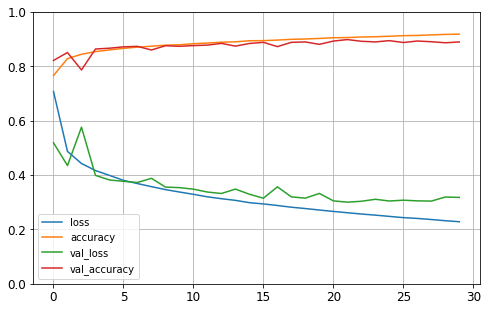

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Évaluation du modele sur le jeu de test. Il est fréquent d'obtenir des performances légèrement moins bonnes sur le jeu de test que sur le jeu de validation car les hyperparamètres sont ajustés non pas sur le jeu de test mais sur le jeu de validation. Il faut éviter d'ajuster les hyêrparamètres sur le jeu de test sinon votre estimation de l'erreur de généralisation sera alors trop optimiste.

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3519 - accuracy: 0.8788


[0.3519230782985687, 0.8787999749183655]

Nous pouvons par la suite utiliser la méthode prédite pour effectuer des prédictions sur de nouvelles observations. Comme nous n'avons pas de nouvelles
instances, nous utilisons simplement les trois premières observations du jeu de test.
Pour chaque observation, le modèle estime une probabilité par classe de la classe0 à la classe9. Par exemple, pour la premiere image de cette liste, il estime que la probabilité qu'elle soit de la classe 9 (bottine) est de 98%, celle de la classe 5 (sandalle) est de 1% et finalement celle de la classe 7 (basket) est de 1%. Les autres classes sont nulles.

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 23ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.98],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

Si nous intéressons uniquement à la classe dont la probabilité est la plus élevée (même si elle est relativement faible), nous utilisons àla place predict_classes()

**Warning**: `model.predict_classes(X_new)` is deprecated. It is replaced with `np.argmax(model.predict(X_new), axis=-1)`.

In [ ]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 [==============================] - 0s 33ms/step


array([9, 2, 1])

In [ ]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [ ]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

La classeur réalise effectievement les bonnes prédictions: voici les résulats en affichant les images correspondantes:

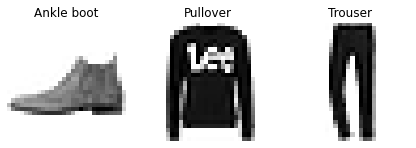

In [ ]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()